# Import the libraries

In [1]:
from glove import Corpus, Glove
import pandas as pd
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize 
import datetime,time
from flashtext.keyword import KeywordProcessor
from nltk.stem import WordNetLemmatizer
from string import punctuation
import re
import pandas as pd
import numpy as np
import string
import multiprocessing
from nltk.corpus import stopwords
from flashtext.keyword import KeywordProcessor
from sklearn.model_selection import train_test_split
from sklearn import metrics

# libraries for dataset preparation, feature engineering, model training 
from sklearn import model_selection, preprocessing, linear_model, naive_bayes, metrics, svm
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn import decomposition, ensemble
#from utils.language_models import WordVectorEmbedding
from gensim.test.utils import datapath, get_tmpfile
#import pandas, xgboost, numpy, textblob, string
from keras.preprocessing import text, sequence
from keras import layers, models, optimizers
# Keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Flatten, LSTM, Conv1D, MaxPooling1D, Dropout, Activation
from keras.layers.embeddings import Embedding
from keras.utils import to_categorical
from sklearn import preprocessing
from keras.layers import Input,GlobalMaxPooling1D
from keras.models import Model

C:\Program Files\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d
C:\Program Files\Anaconda3\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")
Using TensorFlow backend.


## Kaggle challenge link: 
https://www.kaggle.com/c/jigsaw-toxic-comment-classification-challenge

In [19]:
#Some config
MAX_SEQUENCE_LENGTH=100
#Fact: An average native english speaing person remembers 20k words appx.
MAX_VOCAB_SIZE=20000
EMBEDDING_DIM=100
VALIDATION_SPLIT=0.2
BATCH_SIZE=120
EPOCHS=10

In [3]:
#Load in pre-trained vectors
embeddings_index={}
with open(os.path.join('../glove.6B.100d.txt'),encoding='utf8') as f:
    #Space separated text file
    #word1 vec[0] vec[1] vec[2]
    for line in f:
        values=line.split()
        word=values[0]
        vec=np.asarray(values[1:],dtype='float32')
        embeddings_index[word]=vec
print('Found {} word vectors'.format(len(embeddings_index)))

Found 400000 word vectors


## Import dataset

In [4]:
print('Loading comments')
data=pd.read_csv('train.csv')
sentences=data['comment_text'].fillna("DUMMY_VALUE").values
data.head()

Loading comments


,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [5]:
possible_labels=['toxic','severe_toxic','obscene','threat','insult','identity_hate']
targets=data[possible_labels].values

print('Max sequence length: {}'.format(max(len(s) for s in sentences)))
print('Min sequence length: {}'.format(min(len(s) for s in sentences)))
s=sorted(len(s) for s in sentences)
print('Median sequence length : {}'.format(s[len(s)//2]))

Max sequence length: 5000
Min sequence length: 6
Median sequence length : 205


In [6]:
#Convert the sentences into integers
tokenizer=Tokenizer(num_words=MAX_VOCAB_SIZE)
tokenizer.fit_on_texts(sentences)
sequences=tokenizer.texts_to_sequences(sentences)
#sequences

In [7]:
#Get Word->Integer mapping
word2idx=tokenizer.word_index
print('Found {} unique tokens'.format(len(word2idx)))

Found 210337 unique tokens


In [8]:
#Pad sequences to get a N x T Matrix
data_sen=pad_sequences(sequences,maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data vectors : {}'.format(data_sen.shape))

Shape of data vectors : (159571, 100)


In [9]:
#Prepare embedding matrix
# create a weight matrix for words in training docs
#Use the min of these two to ensure if data vocabulary size < MAX_VOCAB_SIZE, we don't train 20000 vectors still
num_words=min(MAX_VOCAB_SIZE,len(word2idx)+1)
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))
for word, index in tokenizer.word_index.items():
    if index > num_words - 1:
        break
    else:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[index] = embedding_vector

In [10]:
embedding_layer=Embedding(num_words,
                       EMBEDDING_DIM,
                       weights=[embedding_matrix],
                       input_length=MAX_SEQUENCE_LENGTH,
                       trainable=False)

In [11]:
#load pre trained vector
#Using pretrained word vector
pretrained_vector_path='../glove.6B.100d.txt'
embeddings_index = dict()
f = open(pretrained_vector_path,encoding='utf8')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('Loaded %s word vectors.' % len(embeddings_index))

Loaded 400000 word vectors.


## Building the Model

#### In some domains, such as natural language processing, it is common to use global max pooling. In some other domains, such as computer vision, it is common to use a max pooling that isn't global.

###### Global max pooling = ordinary max pooling layer with pool size equals to the size of the input (minus filter size + 1, to be precise). You can see that MaxPooling1D takes a pool_length argument, whereas GlobalMaxPooling1D does not. It's defined as Global max pooling operation for temporal data.

##### Conv1D convolution is faster, it works in the same way as Conv2D but assume a 1 dimension array that makes a multiplication with the elements. We would have used Conv2D had we been using CNNs for computer vision

##### Conv1D : This layer creates a convolution kernel that is convolved with the layer input over a single spatial (or temporal) dimension to produce a tensor of outputs

In [12]:
# Train a 1D convent with global maxpooling
input_=Input(shape=(MAX_SEQUENCE_LENGTH,))
x=embedding_layer(input_)
x=Conv1D(64,3,activation='relu')(x)
x=MaxPooling1D(3)(x)
x=Conv1D(64,3,activation='relu')(x)
x=GlobalMaxPooling1D()(x)
x=Dense(64,activation='relu')(x)
output=Dense(len(possible_labels),activation='sigmoid')(x)

Instructions for updating:
Colocations handled automatically by placer.


In [13]:
model=Model(input_,output)
model.compile(loss='binary_crossentropy',optimizer='rmsprop',metrics=['accuracy'])

In [14]:
print("Training Model with two convolution layers.. ")
r=model.fit(data_sen,targets,batch_size=BATCH_SIZE,epochs=EPOCHS,validation_split=VALIDATION_SPLIT)

Training Model with two convolution layers.. 
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Train on 127656 samples, validate on 31915 samples
Epoch 1/10
127656/127656 [==============================] - 66s 520us/step - loss: 0.4907 - acc: 0.9633 - val_loss: 0.3352 - val_acc: 0.9635
Epoch 2/10
127656/127656 [==============================] - 68s 534us/step - loss: 0.2506 - acc: 0.9633 - val_loss: 0.1916 - val_acc: 0.9635
Epoch 3/10
127656/127656 [==============================] - 62s 484us/step - loss: 0.1675 - acc: 0.9633 - val_loss: 0.1520 - val_acc: 0.9635
Epoch 4/10
127656/127656 [==============================] - 60s 469us/step - loss: 0.1465 - acc: 0.9633 - val_loss: 0.1428 - val_acc: 0.9635
Epoch 5/10
127656/127656 [==============================] - 70s 545us/step - loss: 0.1419 - acc: 0.9633 - val_loss: 0.1411 - val_acc: 0.9635
Epoch 6/10
127656/127656 [==============================] - 62s 483us/st

In [15]:
model_glove = Sequential()
model_glove.add(Embedding(input_dim=MAX_VOCAB_SIZE, output_dim=EMBEDDING_DIM, input_length=EMBEDDING_DIM, weights=[embedding_matrix], trainable=False))
model_glove.add(Dropout(0.2))
model_glove.add(Conv1D(64, 5, activation='relu'))
model_glove.add(MaxPooling1D(pool_size=4))
model_glove.add(LSTM(100))
model_glove.add(Dense(6))
model_glove.add(Activation('softmax'))
model_glove.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [21]:
r_glove=model_glove.fit(data_sen, targets, validation_split=VALIDATION_SPLIT, epochs = EPOCHS)

Train on 127656 samples, validate on 31915 samples
Epoch 1/10
127656/127656 [==============================] - 191s 1ms/step - loss: 0.3014 - acc: 0.9942 - val_loss: 0.3017 - val_acc: 0.9941
Epoch 2/10
127656/127656 [==============================] - 190s 1ms/step - loss: 0.3012 - acc: 0.9942 - val_loss: 0.3010 - val_acc: 0.9941
Epoch 3/10
127656/127656 [==============================] - 189s 1ms/step - loss: 0.3012 - acc: 0.9942 - val_loss: 0.3009 - val_acc: 0.9941
Epoch 4/10
127656/127656 [==============================] - 193s 2ms/step - loss: 0.3012 - acc: 0.9942 - val_loss: 0.3010 - val_acc: 0.9941
Epoch 5/10
127656/127656 [==============================] - 176s 1ms/step - loss: 0.3012 - acc: 0.9942 - val_loss: 0.3011 - val_acc: 0.9941
Epoch 6/10
127656/127656 [==============================] - 176s 1ms/step - loss: 0.3012 - acc: 0.9942 - val_loss: 0.3016 - val_acc: 0.9941
Epoch 7/10
127656/127656 [==============================] - 198s 2ms/step - loss: 0.3011 - acc: 0.9942 - val_

In [ ]:
mm = Sequential()
mm.add(Embedding(input_dim=MAX_VOCAB_SIZE, output_dim=EMBEDDING_DIM, input_length=EMBEDDING_DIM, weights=[embedding_matrix], trainable=False))
mm.add(Dropout(0.2))
mm.add(Conv1D(64, 5, activation='relu'))
mm.add(MaxPooling1D(pool_size=4))
mm.add(LSTM(100))
mm.add(Dense(6))
mm.add(Activation('softmax'))
mm.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [24]:
r_glove.history

{'acc': [0.9941796703641035,
  0.9941796703641035,
  0.9941796703641035,
  0.9941796703641035,
  0.9941796703641035,
  0.9941796703641035,
  0.9941796703641035,
  0.9941796703641035,
  0.9941796703641035,
  0.9941796703641035],
 'loss': [0.3014033645920947,
  0.3012325596719179,
  0.3012153624768297,
  0.3011832482010423,
  0.3011662701138161,
  0.3011526834452452,
  0.3011415583010514,
  0.3011418332418097,
  0.3011046326128867,
  0.3011110898084178],
 'val_acc': [0.9941093529688234,
  0.9941093529688234,
  0.9941093529688234,
  0.9941093529688234,
  0.9941093529688234,
  0.9941093529688234,
  0.9941093529688234,
  0.9941093529688234,
  0.9941093529688234,
  0.9941093529688234],
 'val_loss': [0.3017428184963778,
  0.30103196908403074,
  0.3008999856459988,
  0.30102547185091916,
  0.30110923507343207,
  0.3015697125896996,
  0.30151762661283227,
  0.30086932463573474,
  0.30106119584387303,
  0.30091216376670826]}

In [27]:
#Plot data
#model_glove

import matplotlib.pyplot as plt,plt2
from sklearn.metrics import roc_auc_score

plt.plot(r_glove.history['loss'],label='loss')
plt.plot(r_glove.history['val_loss'],label='val_loss')
plt.legend()
plt.show()

#Accuracies
plt.plot(r_glove.history['acc'],label='acc')
plt.plot(r_glove.history['val_acc'],label='val_acc')
plt.legend()
plt.show()

#Plot mean AUC over each label
p=model_glove.predict(data_sen)
auc_list=[]
for j in range(6):
    auc=roc_auc_score(targets[:,j],p[:,j])
    auc_list.append(auc)
print(np.mean(auc_list))

ImportError: No module named 'plt2'

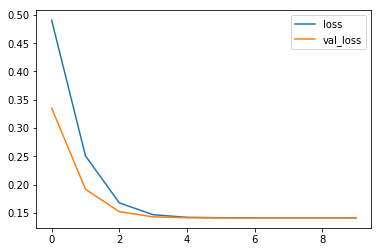

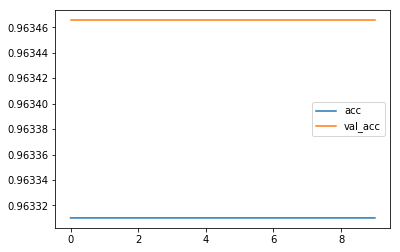

0.5000010762241561


In [23]:
#Plot data
#r
plt.plot(r.history['loss'],label='loss')
plt.plot(r.history['val_loss'],label='val_loss')
plt.legend()
plt.show()

#Accuracies
plt.plot(r.history['acc'],label='acc')
plt.plot(r.history['val_acc'],label='val_acc')
plt.legend()
plt.show()

#Plot mean AUC over each label
p=model.predict(data_sen)
auc_list=[]
for j in range(6):
    auc=roc_auc_score(targets[:,j],p[:,j])
    auc_list.append(auc)
print(np.mean(auc_list))

In [29]:
model_glove.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 100, 100)          2000000   
_________________________________________________________________
dropout_1 (Dropout)          (None, 100, 100)          0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 96, 64)            32064     
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 24, 64)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               66000     
_________________________________________________________________
dense_3 (Dense)              (None, 6)                 606       
_________________________________________________________________
activation_1 (Activation)    (None, 6)                 0         
Total para

In [30]:
mm = Sequential()
mm.add(Embedding(input_dim=MAX_VOCAB_SIZE, output_dim=EMBEDDING_DIM, input_length=EMBEDDING_DIM, weights=[embedding_matrix], trainable=False))
mm.add(Dropout(0.2))
#mm.add(Conv1D(64, 5, activation='relu'))
#mm.add(MaxPooling1D(pool_size=4))
mm.add(LSTM(100))
mm.add(Dense(6))
mm.add(Activation('softmax'))
mm.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [31]:
mm.fit(data_sen, targets, validation_split=VALIDATION_SPLIT, epochs = EPOCHS)

Train on 127656 samples, validate on 31915 samples
Epoch 1/10
127656/127656 [==============================] - 213s 2ms/step - loss: 0.3024 - acc: 0.9942 - val_loss: 0.3017 - val_acc: 0.9941
Epoch 2/10
127656/127656 [==============================] - 24775s 194ms/step - loss: 0.3014 - acc: 0.9942 - val_loss: 0.3010 - val_acc: 0.9941
Epoch 3/10
127656/127656 [==============================] - 219s 2ms/step - loss: 0.3012 - acc: 0.9942 - val_loss: 0.3012 - val_acc: 0.9941
Epoch 4/10
127656/127656 [==============================] - 188s 1ms/step - loss: 0.3011 - acc: 0.9942 - val_loss: 0.3010 - val_acc: 0.9941
Epoch 5/10
127656/127656 [==============================] - 175s 1ms/step - loss: 0.3012 - acc: 0.9942 - val_loss: 0.3011 - val_acc: 0.9941
Epoch 6/10
127656/127656 [==============================] - 184s 1ms/step - loss: 0.3011 - acc: 0.9942 - val_loss: 0.3009 - val_acc: 0.9941
Epoch 7/10
127656/127656 [==============================] - 183s 1ms/step - loss: 0.3010 - acc: 0.9942 - 